<a href="https://colab.research.google.com/github/sushirito/Hg2/blob/main/2D_Pore_Reaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.5 MB/s eta 0:00:00


Compiling model...
Building feed-forward neural network...
'build' took 0.068546 s

'compile' took 0.953315 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.86e-02, 9.21e-02]    [2.08e-02, 9.21e-02]    []  
1000      [4.64e-07, 3.43e-08]    [3.36e-07, 3.43e-08]    []  
2000      [1.18e-05, 3.70e-05]    [1.21e-05, 3.70e-05]    []  
3000      [6.40e-08, 5.61e-08]    [6.18e-08, 5.61e-08]    []  
4000      [3.13e-08, 1.75e-09]    [2.68e-08, 1.76e-09]    []  
5000      [1.80e-08, 6.81e-10]    [1.49e-08, 6.81e-10]    []  
6000      [9.77e-09, 3.58e-10]    [7.50e-09, 3.58e-10]    []  
7000      [5.62e-09, 5.30e-10]    [3.99e-09, 5.30e-10]    []  
8000      [2.57e-08, 7.23e-08]    [1.95e-08, 7.23e-08]    []  
9000      [2.38e-09, 4.98e-10]    [2.21e-09, 4.98e-10]    []  
10000     [1.27e-09, 2.16e-10]    [1.13e-09, 2.16e-10]    []  

Best model at step 10000:
  train loss: 1.48e-09
  test loss: 1.35e-09
  test metric: []

'train' took 18.

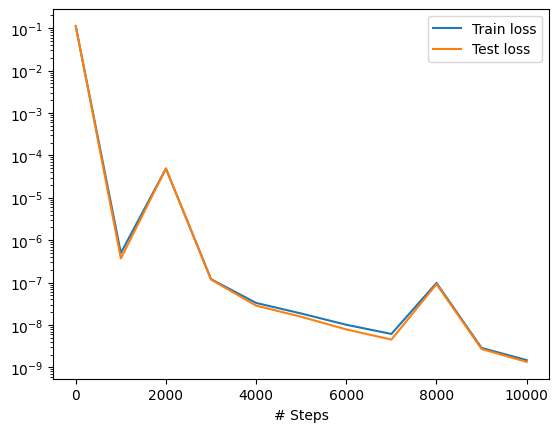

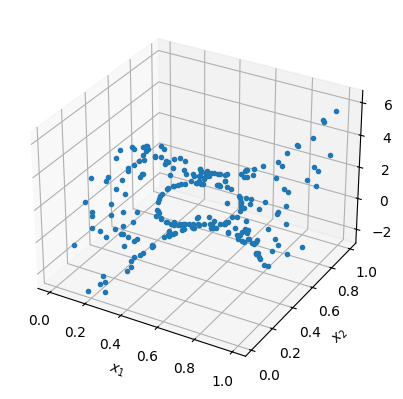

In [9]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

D = 1.0
k = 0.1
alpha = 1.0

outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
inclusion = dde.geometry.Disk(center=[0.5, 0.5], radius=0.2)
fluid_domain = outer - inclusion

def robin_func(x, u):
    return k * (alpha - u)

def boundary_solid(x, on_boundary):
    return on_boundary and inclusion.on_boundary(x)

robin_bc = dde.icbc.RobinBC(
    fluid_domain,
    func=robin_func,
    on_boundary=boundary_solid
)


def pde(x, u):
    d2u_dx2 = dde.grad.hessian(u, x, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(u, x, i=1, j=1)
    return D * (d2u_dx2 + d2u_dy2)  # grad^2(u) = 0

data = dde.data.PDE(
    fluid_domain,
    pde,
    [robin_bc],
    num_domain=1000,
    num_boundary=100,
    solution=None,
    num_test=200,
)

net = dde.nn.FNN(
    [2] + [50] * 4 + [1],
    "tanh",
    "Glorot normal",
)

# 5. Model Compilation
model = dde.Model(data, net)
model.compile("adam", lr=0.001)


losshistory, train_state = model.train(
    iterations=10000,
)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

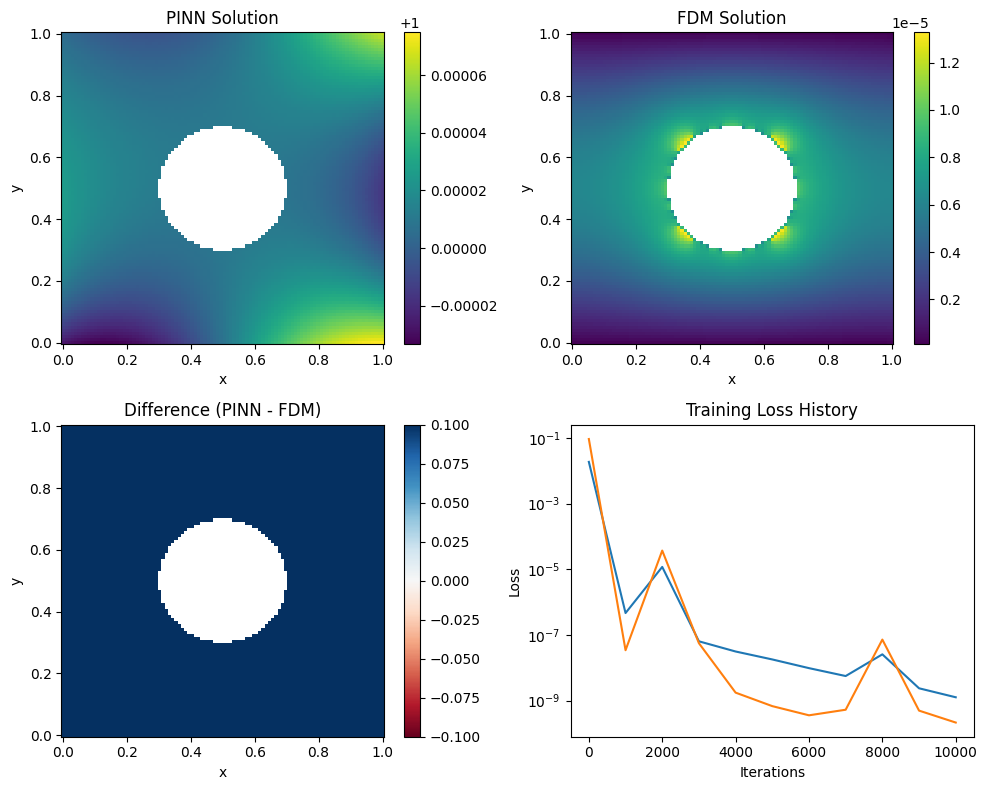

In [11]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
X_flat = X.flatten()[:, None]
Y_flat = Y.flatten()[:, None]
points = np.hstack((X_flat, Y_flat))

Z_pinn = model.predict(points)[:, 0].reshape(X.shape)

mask = (X - 0.5)**2 + (Y - 0.5)**2 <= 0.2**2
Z_pinn[mask] = np.nan

plt.figure(figsize=(10, 8))
plt.subplot(221)
im = plt.pcolormesh(X, Y, Z_pinn, shading='auto', cmap='viridis')
plt.colorbar(im)
plt.title('PINN Solution')
plt.xlabel('x')
plt.ylabel('y')

def fdm_solution(nx, ny, D, k, alpha):
    dx = 1.0 / (nx - 1)
    dy = 1.0 / (ny - 1)

    main_diag = -2 * (1/dx**2 + 1/dy**2) * np.ones(nx*ny)
    off_diag_x = 1/dx**2 * np.ones(nx*ny-1)
    off_diag_y = 1/dy**2 * np.ones(nx*ny-ny)

    A = diags([main_diag, off_diag_x, off_diag_x, off_diag_y, off_diag_y],
              [0, 1, -1, ny, -ny], format='csr')

    b = np.zeros(nx*ny)
    for i in range(nx):
        for j in range(ny):
            idx = i*ny + j
            x, y = i*dx, j*dy
            if (x-0.5)**2 + (y-0.5)**2 <= 0.2**2:
                A[idx, :] = 0
                A[idx, idx] = 1
                b[idx] = 0
            elif (x-0.5)**2 + (y-0.5)**2 <= 0.21**2:  # Boundary approx
                A[idx, idx] -= k/D
                b[idx] = -k*alpha/D

    u = spsolve(A, b)
    return u.reshape((nx, ny))

Z_fdm = fdm_solution(100, 100, D, k, alpha)
Z_fdm[mask] = np.nan

plt.subplot(222)
im = plt.pcolormesh(X, Y, Z_fdm, shading='auto', cmap='viridis')
plt.colorbar(im)
plt.title('FDM Solution')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(223)
diff = Z_pinn - Z_fdm
im = plt.pcolormesh(X, Y, diff, shading='auto', cmap='RdBu', vmin=-0.1, vmax=0.1)
plt.colorbar(im)
plt.title('Difference (PINN - FDM)')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(224)
plt.semilogy(losshistory.steps, losshistory.loss_train)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss History')

plt.tight_layout()
plt.show()